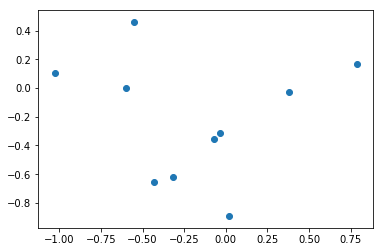

In [1]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
from itertools import combinations
from matplotlib.lines import Line2D
import networkx as nx
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

#set random seed
np.random.seed(300)

# load wheel point cloud
wheel = np.genfromtxt('data/wheel.txt', delimiter=' ')

# select random indicies from the point cloud
random_indices = np.random.choice(wheel.shape[0], 10)

# subset the point cloud
subcloud = wheel[random_indices, ]

plt.scatter(subcloud[:, 0], subcloud[:, 1]) # plot the subcloud
plt.show()

## Part 4. Triangulations on a point cloud

To introduce a new algorithm for a better 1-dimensional skeleton, we will need to increase the dimension (from 1 to 2) and consider a sequence of 2D triangulations with vertices at the points of a given cloud in the plane. 

These triangulations are called alpha-complexes and they are contained in a Delaunay triangulation, which is defined below through a Voronoi diagram.

The following code outputs a toy example of 10 points in the plane, which will be frequently used later.  

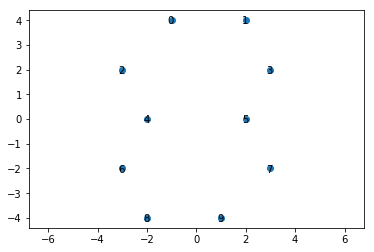

In [2]:
# create toy point cloud
points = np.array([[-1, 4], [2, 4], [-3, 2], [3, 2], [-2, 0],
                   [2,0], [-3, -2], [3, -2], [-2, -4], [1, -4]])
#plot
plt.plot(points[:,0], points[:,1], 'o')

# annotate the points
for i,p in enumerate(points):
    plt.text(p[0]-0.03, p[1]-0.03, i, ha="center", va="center")
    
plt.axis('equal')
plt.show()

### 4.1. The Voronoi cell of a point in a cloud

For a point $p_i$ within a cloud $C=\{p_1,\dots,p_n\}$ in any Euclidean space ${\mathbb R}^d$, the <i>Voronoi cell</i> $V(p_i)$ is the neighborhood of $p_i$ consisting of all points $q\in{\mathbb R}^d$ that are (non-strictly) closer to $p_i$ than to other points of the cloud $C$.

More formally, the <i>Voronoi cell</i> is $V(p_i)=\{q\in {\mathbb R}^d \; |\; d_2(q,p_i)\leq d_2(q,p_j) \mbox{ for any } j\neq i\}$, where $d_2$ is the Euclidean distance in ${\mathbb R}^d$.

The code below outputs boundary lines between the Voronoi cells of the 10-point cloud. Notice that only the Voronoi cells of points 4 and 5 are bounded, all other Voronoi cells are unbounded in the plane.

In a general position in ${\mathbb R}^2$, only 3 Voronoi cells can share a common point on their boundaries. However, points 0,1,3,5 (similarly, points 4,6,8,9) lie in the same circle, whose center belongs to the boundaries of the corresponding four Voronoi cells.

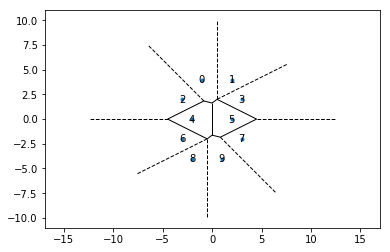

In [3]:
vor = Voronoi(points)
f = voronoi_plot_2d(vor, show_vertices=False)
for i,p in enumerate(points):
    plt.text(p[0]-0.03, p[1]-0.03, i, ha="center", va="center")
plt.axis('equal')
plt.show()

### 4.2. The Voronoi diagram of a point cloud

The <i>Voronoi diagram</i> of a cloud $C\subset{\mathbb R}^d$ is a splitting of ${\mathbb R}^d$ into Voronoi cells $V(p_i)$, $i=1,\dots,n$, which share common boundaries.

The code below outputs the Voronoi diagram for a subcloud of the noisy sample from the wheel graph you have seen earlier. Feel free to change the number of points in the subcloud.

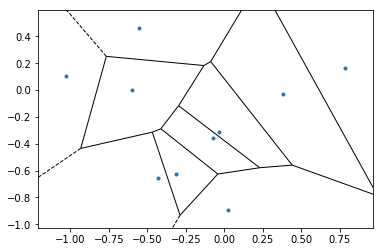

In [4]:
wheel = np.genfromtxt('data/wheel.txt', delimiter=' ')
np.random.seed(300)
random_indices = np.random.choice(wheel.shape[0], 10)
w = wheel[random_indices, ]
vor = Voronoi(w)
f = voronoi_plot_2d(vor, show_vertices=False)
plt.show()

### 4.3. A Delaunay triangulation of a cloud

A <i>Delaunay triangulation</i> $Del(C)$ of a cloud $C\subset{\mathbb R^2}$ consists of the following edges and triangles with vertices at the points of $C$. Two points $p_i,p_j$ are connected by a <i>Delaunay</i> edge if their Voronoi cells $V(p_i),V(p_j)$ share a common boundary line. Three points $p_i,p_j,p_k$ span a <i>Delaunay</i> triangle if their Voronoi cells $V(p_i),V(p_j),V(p_k)$ share a common point on their boundaries.

The code below shows a Delaunay triangulation on the 10-point cloud above.

In [5]:
def plot_triangulation(tri, points, label=True):
    plt.plot(points[:,0], points[:,1], 'o')
    
    if label:
        for i,p in enumerate(points):
            plt.text(p[0]+0.5, p[1], i,
                     ha="center", va="center")
            
    plt.triplot(points[:,0], points[:,1],
                tri.simplices.copy())
    plt.axis('equal')
    return plt.show()

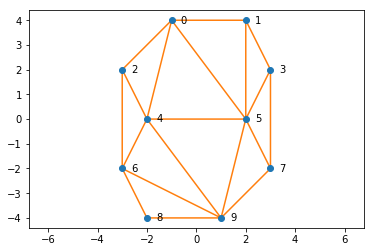

In [6]:
plot_triangulation(Delaunay(points), points)

The definition above uniquely determines a collection of non-intersecting triangles if the cloud $C$ is in a <i>general position</i>, which means here that there are no four or more points lying in the same circle. 

In a degenerate case when points $p_i,p_j,p_k,p_l$ lie in the same circle, the quadrilateral on these points is inscribed into the circle and can be split in two pairs of triangles (by any of the diagonal $p_ip_k$ or $p_jp_l$). So a Delaunay triangulation $Del(C)$ is not unique for a degenerate point cloud $C$. The code above outputs one possible Delaunay triangulation.

The full Delaunay triangulation subdivides the <i>convex hull</i> on a point cloud $C$, which is the smallect convex polygon containing all points of $C$.

The <i>convex hull</i> of $C$ can be also defined as the intersection of all half-planes containing $C$.

All the above concepts can be extended to the Euclidean space ${\mathbb R}^d$ of any dimension, though we illustrate them for simplicity in the plane.

The following code outputs a Delaunay triangulation of a subcloud generated earlier.

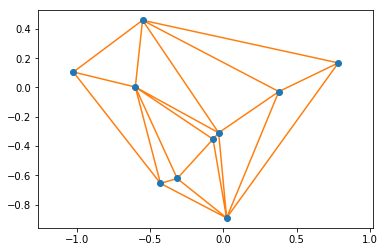

In [7]:
plot_triangulation(Delaunay(subcloud), subcloud, label=False)

### 4.4. Thickenings of a point cloud

A convex hull and a Delaunay triangulation are good representatives for discrete samples of convex shapes. However many shapes and (representations of) real data are not convex.

In early 1980s Prof Herbert Edelsbrunner has introduced a non-convex analogue of a Delaunay triangulation, which he has called an <i>alpha-shape</i> depending on a scale parameter $\alpha$. 

Here is the first motivation (a joke :-) to study $\alpha$-shapes : "Don't look like a convex hull, get yourself into an alpha-shape!"

These $\alpha$-shapes are now more often called $\alpha$-complexes or Delaunay complexes (triangulations) at a scale $\alpha$.

Before giving a formal definition, let's mention another motivation, more exactly a theorem saying that $\alpha$-complexes are topologically correct representatives for thickenings of a point cloud.

A thickening produced by the code below will discussed right before the outputs.

In [18]:
def plot_circle(ax, radius, point, polygon):
    # create a matplotlib circle
    circle = plt.Circle((point[0], point[1]), radius, 
                        color='b', clip_on=True)
    # clip the circle based on the voronoi region
    ax.add_patch(polygon)
    circle.set_clip_path(polygon)
    # add the circle to the axes
    ax.add_patch(circle)

    
def sort_points_counterclockwise(polygon):
    # get the center
    c = polygon.mean(axis=0)
    # compute the angle to the centre
    angles = np.arctan2(polygon[:,1] - c[1],
                        polygon[:,0] - c[0])
    # order the points counter clockwise
    return polygon[np.argsort(angles)]
    
    
def draw_alpha_offset(points, vor, alpha, equal=False):
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    # get the center of the points and the radius
    center = vor.points.mean(axis=0)
    radius = vor.points.ptp().max()
    
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    
    for point in range(len(points)):
        # for each region get the points in
        # the voronoi diagram that define it
        region = vor.point_region[point]
        vs = vor.regions[region]
        
        # if the region is finite, create a polygon
        # from the voronoi points
        if all(v >= 0 for v in vs):
            polygon = vor.vertices[vs].copy()
        
        else:
            # if the point has no ridges continue
            if point not in all_ridges:
                continue
            # get all the ridges associated with the point            
            ridges = all_ridges[point]
            # add all finite points to the polygon
            polygon = vor.vertices[[v for v in vs if v >= 0]]
            
            # go though each ridge and approximate inifite voronoi areas for plotting
            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    # finite ridge: already in the region
                    continue

                # Compute the missing endpoint of an infinite ridge
                t = vor.points[p2] - vor.points[point] # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal
                midpoint = vor.points[[point, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius
                # add to the polygon
                polygon = np.vstack((polygon, far_point))
                
            polygon = sort_points_counterclockwise(polygon)
        # add the end point    
        polygon = np.vstack((polygon, polygon[0]))
        # plot the clipped circle
        plot_circle(ax, alpha, points[point],
                    plt.Polygon(polygon,
                                visible=False))
    
    # overlay axes with the voronoi diagram    
    voronoi_plot_2d(vor, ax=ax, show_vertices=False)

    ax.axis('off')
    if equal:
        ax.axis('equal')
    return plt.show()

For a scale $\alpha$, the $\alpha$-thickening (or the $\alpha$-offset) $C^{\alpha}$ of a point cloud $C$ is the union of balls of the radius $\alpha$ and centers at all points $p\in C$. 

When the scale $\alpha$ increases from $0$ to a large value, the offset $C^{\alpha}$ grows from the isolated points of $C$ to larger and non-trivial shapes.

Increasing the scale is similar to viewing the data through lenses of a variable magnitude. Initially all data points are well-visible as isolated dots. When the magnitude decreases, the data points become blurred and start forming larger and larger clusters, which merge into complicated patterns (depending on data).

The new idea here is not to fix any scale (or a threshold), but to analyse the data across all scales. The short code below draws $\alpha$-offsets for different values of $\alpha$.

Alpha offset at 0.5


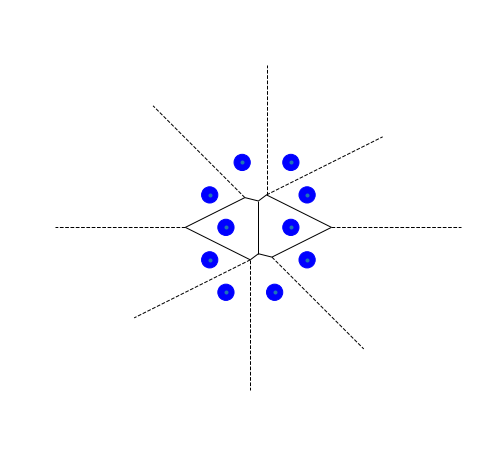

Alpha offset at 1.2


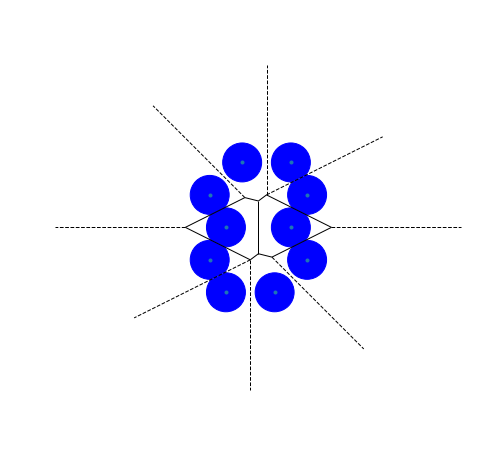

Alpha offset at 1.5


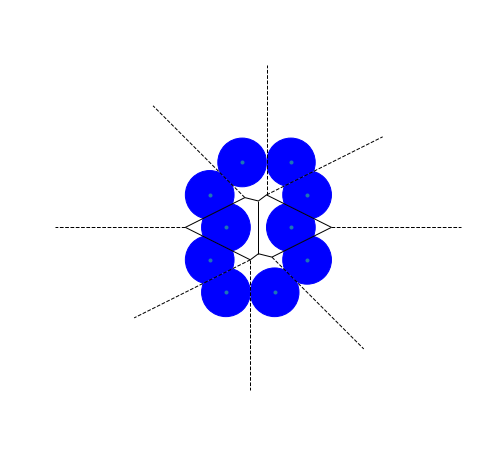

Alpha offset at 2


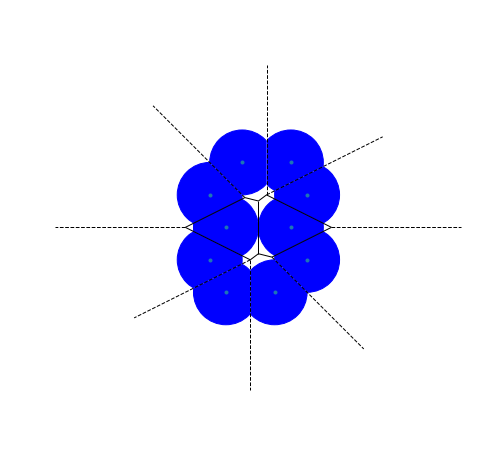

Alpha offset at 2.4


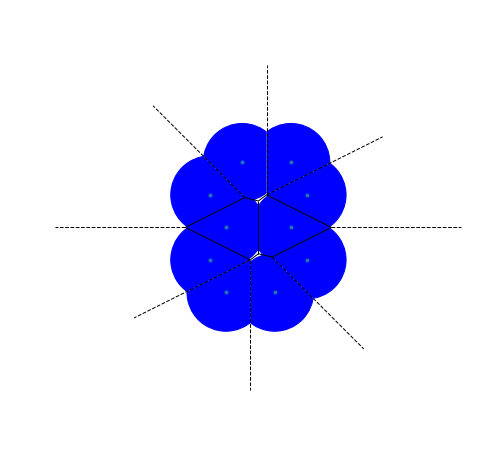

Alpha offset at 3


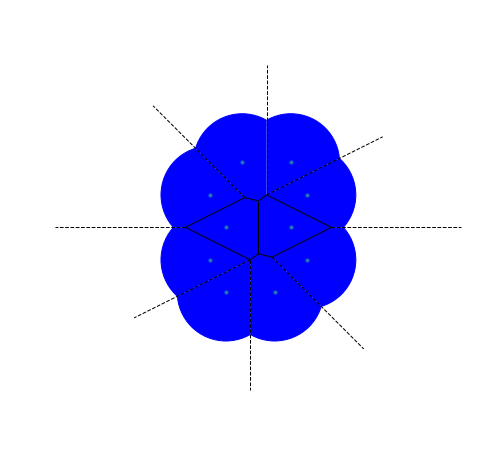

In [27]:
for alpha in [0.5, 1.2, 1.5, 2, 2.4, 3]:
    print(f'Alpha offset at {alpha}')
    draw_alpha_offset(points, Voronoi(points), alpha, True)

Starting from a rather noisy and sparse sample of the wheel graph, we may already recognize the topological shape of a graph when the scale $\alpha$ increases. Feel free to change (or add) values of $\alpha$ in the code below.

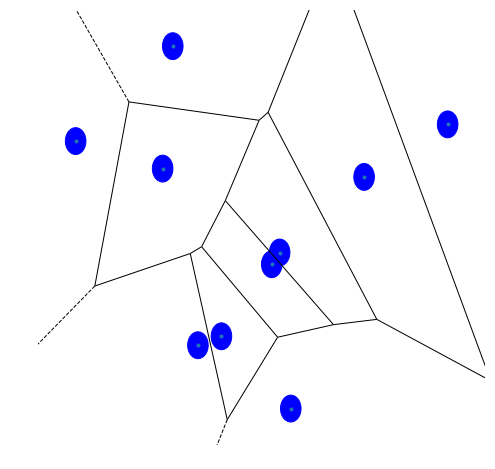

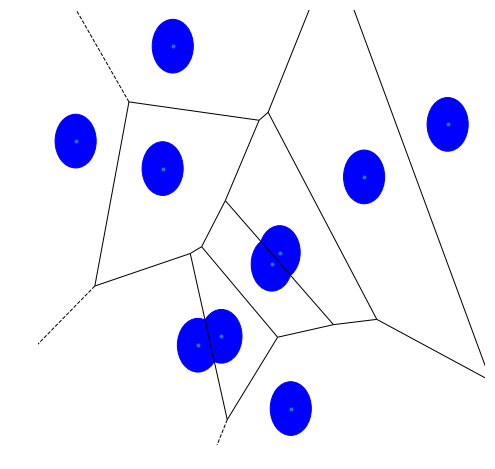

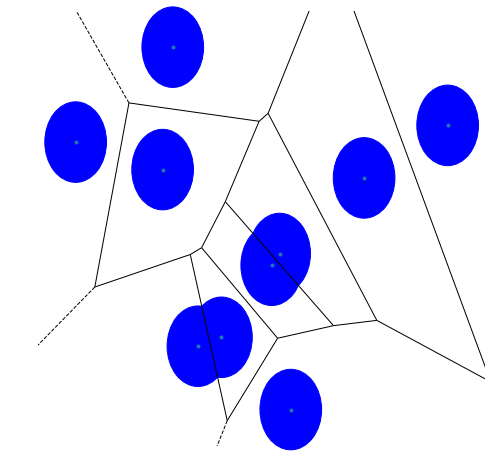

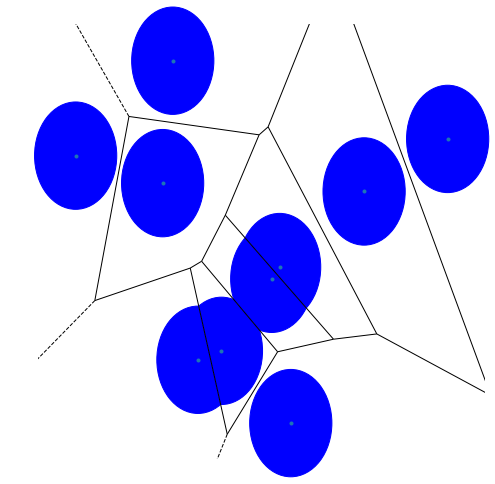

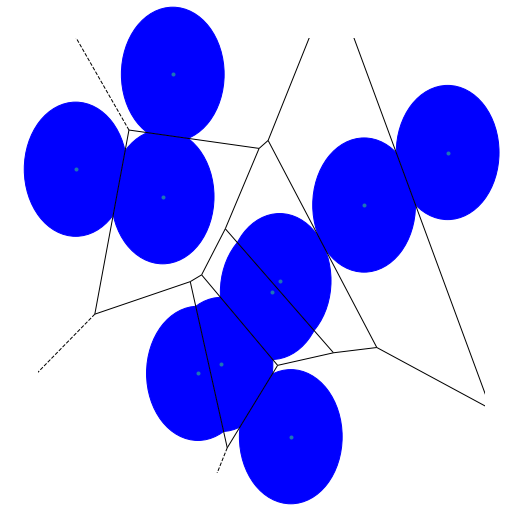

In [10]:
for alpha in [0.05, 0.1, 0.15, 0.2, 0.25]:
    draw_alpha_offset(subcloud,
                      Voronoi(subcloud), alpha)

### 4.5. Alpha-complexes of a point cloud

For a point cloud $C$ and a scale $\alpha>0$, the $\alpha$-complex $C(\alpha)\subset Del(C)$ has the vertices at all elements (vertices, edges, triangles) of $Del(C)$ that are covered b the $\alpha$-offset $C^{\alpha}$.

Informally, the $\alpha$-complex $C(\alpha)$ is a Delaunay triangulation $Del(C)$ restricted to the scale $\alpha$. One can define $C(\alpha)$ via Voronoi cells (restricted to balls of radius $\alpha$) similarly to Delaunay triangulations.

The code below outputs $\alpha$-complexes $C(\alpha)$ of the 10-point cloud $C$ for different values of $\alpha$.

In [21]:
from collections import defaultdict
import itertools

def get_voronoi_neighbours(points):
    # calculate a Delaunay triangluation, in order to get
    # a list of all edges and triangles incident to every vertex
    tri = Delaunay(points)
    edgeList=defaultdict(set)
    triList = defaultdict(set)

    for face in tri.simplices:
         
        for i in face:
            triList[i].add(frozenset(face))

        for u,v in itertools.combinations(face,2):
            edgeList[u].add(v)
            edgeList[v].add(u)
            
    return squareform(pdist(points)), tri, edgeList, triList

In [22]:
def draw_complex(simplex, tri):
    
    # create Axes
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # plot all triangles
    for triangle in simplex[2]:
        t = plt.Polygon(tri.points[list(triangle)], color='orange')
        ax.add_patch(t)

    # plot all edges
    for edge in simplex[1]:
        u, v = tri.points[list(edge)]
        l = Line2D([u[0], v[0]], [u[1], v[1]],
                    c='black', linewidth=1)
        ax.add_line(l)
        
    # plot all verticies of the simplex
    ax.plot(tri.points[:,0], tri.points[:,1], 'o')
    
    return plt.show()

In [23]:
def getRadius(points):
    
    p1 = points[0]
    p2 = points[1]
    p3 = points[2]
    
    a = distance.euclidean(p1, p3)
    b = distance.euclidean(p2, p3)
    c = distance.euclidean(p1, p2)
    
    radius = (a*b*c)/ math.sqrt((a+b+c)*(a+b-c)*(a+c-b)*(c+b-a))
    
    return radius

In [24]:
def isAcute(points):
    
    p1 = points[0]
    p2 = points[1]
    p3 = points[2]
    
    a = distance.euclidean(p1, p3)
    b = distance.euclidean(p2, p3)
    c = distance.euclidean(p1, p2)
    
    if a*a + b*b <= c*c :
        return 0
    if c*c + b*b <= a*a :
        return 0
    if a*a + c*c <= b*b :
        return 0
    
    return 1

In [25]:
def construct_complex(A, tri, edgeList, triList, alpha):
    
    complx = [set([]), 
               set([]), 
               set([])]
    # the o simple
    complx[0] = list(range(len(tri.points)))
        
    for p in range(len(tri.points)):
        
        for neighbour in edgeList[p]:
            if A[p][neighbour] <= alpha*2:
                complx[1].add(frozenset({p, neighbour}))

        for triangle in triList[p]:
            if getRadius(tri.points[list(triangle)]) <= alpha:
                complx[2].add(frozenset(triangle))
 
        for triangle in triList[p]:
            if isAcute(tri.points[list(triangle)]) == 1 :
                break
            # below we check a non-acute triangle
            short_edges = 0
            for u,v in itertools.combinations(triangle,2):
                if A[u][v] <= alpha*2:
                    short_edges = short_edges + 1    
            if short_edges == 3 :
                complx[2].add(frozenset(triangle))
                
    return complx

alpha=1.2


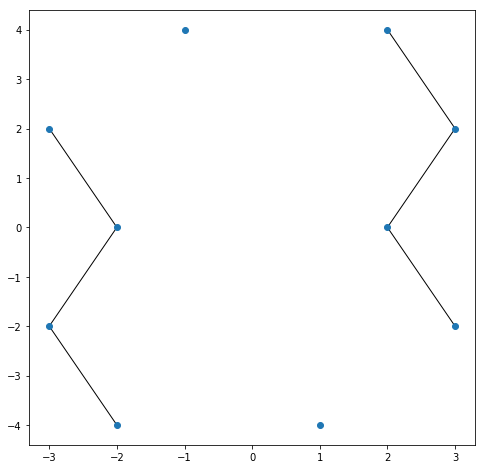

alpha=1.5


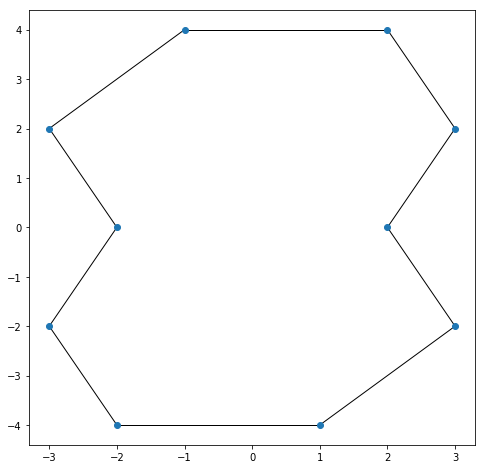

alpha=2


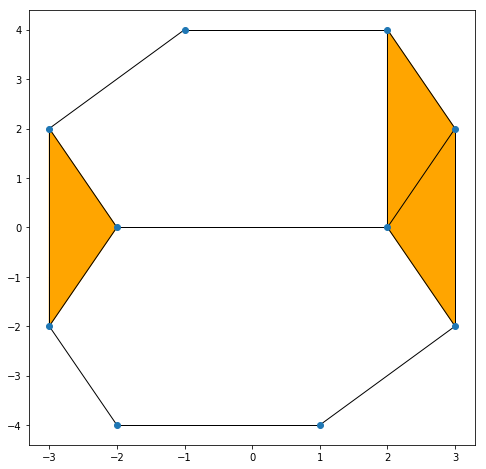

alpha=2.2


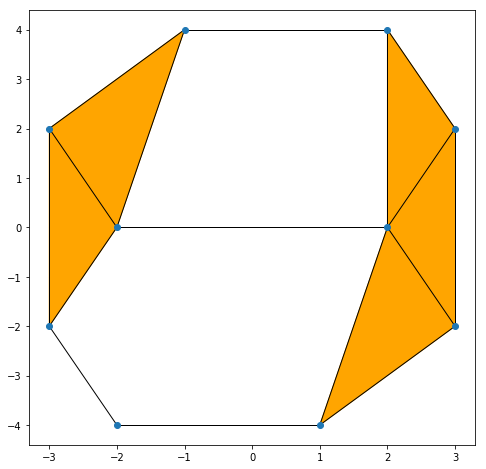

alpha=2.5


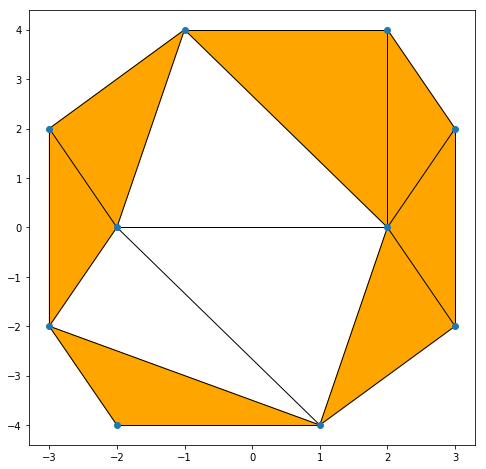

alpha=2.55


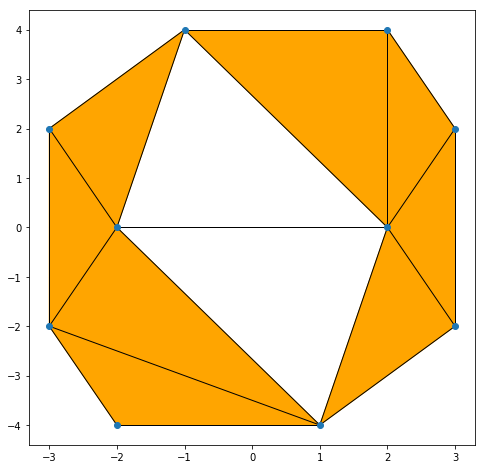

alpha=3


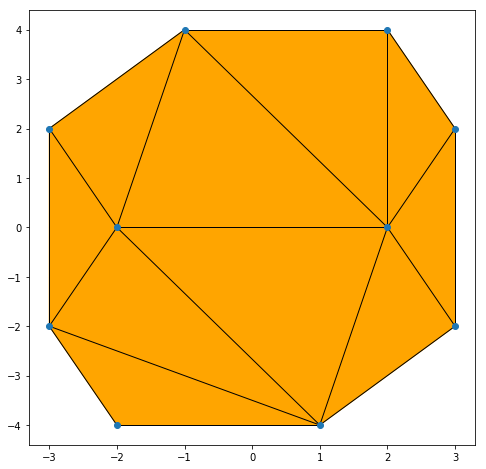

In [26]:

dist_matrix, tri, edgeList, triList = get_voronoi_neighbours(points)

for alpha in [1.2, 1.5, 2, 2.2, 2.5, 2.55, 3]:
    print( 'alpha=' + str(alpha) )
    s = construct_complex(dist_matrix, tri, edgeList, triList, alpha)
    draw_complex(s,tri)

The code below outputs $\alpha$-complexes $C(\alpha)$ for the subcloud generated earlier from the wheel graph.

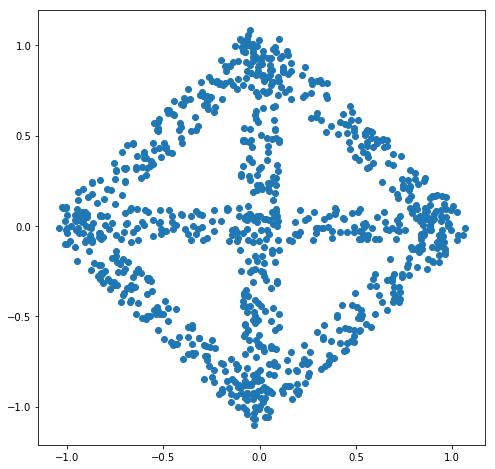

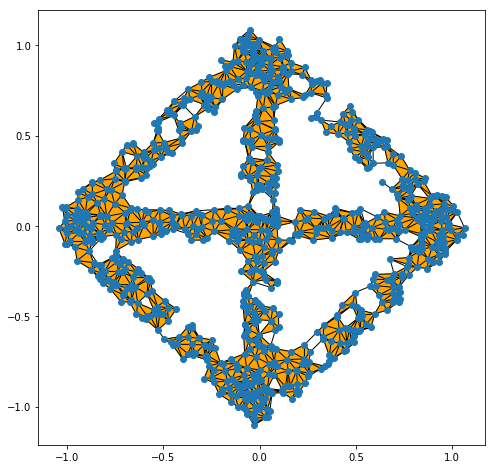

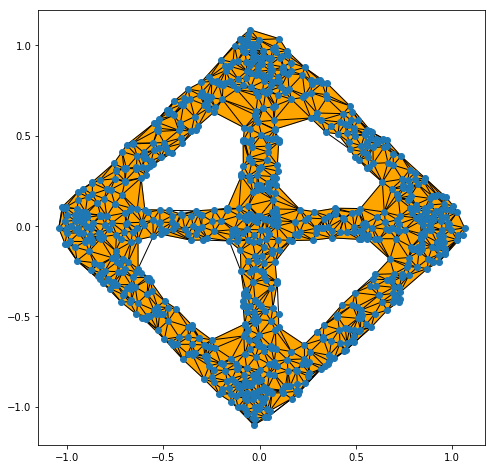

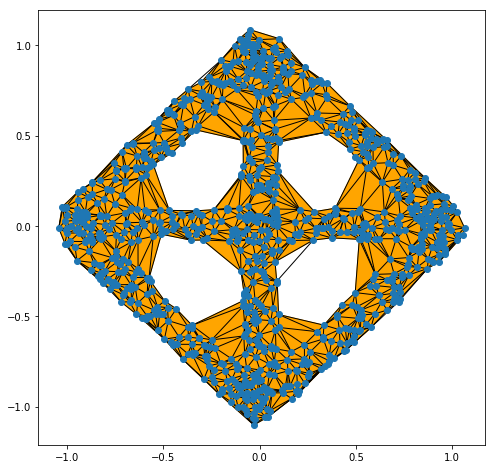

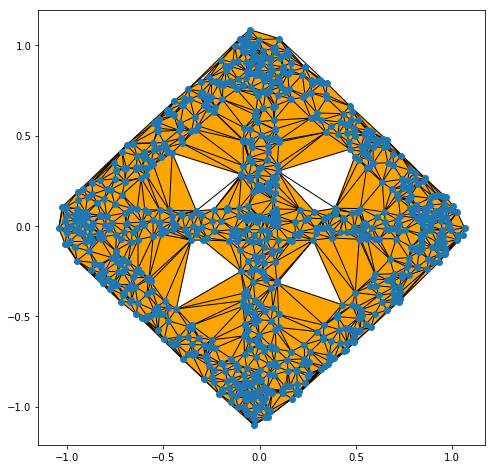

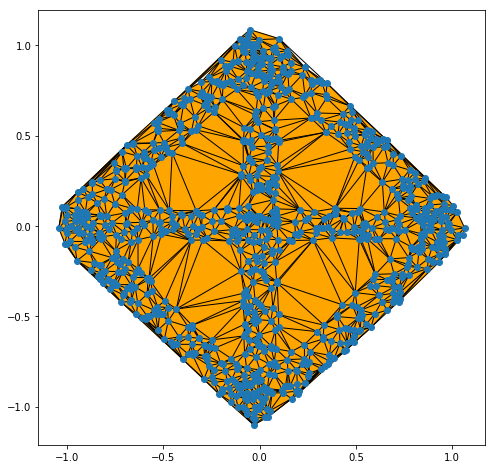

In [28]:
dist_matrix, tri, edgeList, triList = get_voronoi_neighbours(wheel)

for alpha in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
    s = construct_complex(dist_matrix, tri, edgeList, triList, alpha)
    draw_complex(s, tri)